In [ ]:
!pip install scikit-image


In [ ]:
# Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths (MODIFY THESE)
DATASET_PATH = r"C:\Users\linga\OneDrive\Desktop\mini\tiff"
TRAIN_IMAGE_DIR = os.path.join(DATASET_PATH, "train")
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, "train_labels")
VAL_IMAGE_DIR = os.path.join(DATASET_PATH, "val")
VAL_MASK_DIR = os.path.join(DATASET_PATH, "val_labels")

In [ ]:
class BinarizeMask(nn.Module):
    def forward(self, x):
        return (x > 0).float()

class PairedTransform:
    def __init__(self, image_size=256):
        self.image_size = image_size
        self.image_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            # Optional: Uncomment for augmentation
            # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            BinarizeMask()
        ])

    def __call__(self, img, mask):
        if torch.rand(1) > 0.5:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        if torch.rand(1) > 0.5:
            img = transforms.functional.vflip(img)
            mask = transforms.functional.vflip(mask)
        return self.image_transform(img), self.mask_transform(mask)

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff')])
        self.masks = sorted([f.replace('.tiff', '.tif') for f in self.images])

        assert len(self.images) == len(self.masks), "Mismatched dataset sizes!"
        for img, msk in zip(self.images, self.masks):
            assert os.path.exists(os.path.join(mask_dir, msk)), f"Missing mask for {img}"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.images[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert('L')
        if self.transform:
            img, mask = self.transform(img, mask)
        return img, mask


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder
        self.enc1 = self._block(in_channels, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)

        # Bottleneck
        self.bottleneck = self._block(512, 1024)

        # Decoder with corrected input channels after concatenation
        self.up4 = self._upblock(1024, 512)
        self.up3 = self._upblock(1024, 256)  # 512 + 512
        self.up2 = self._upblock(512, 128)   # 256 + 256
        self.up1 = self._upblock(256, 64)    # 128 + 128

        # Final convolution block after concat with e1
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2)
        )

    def _upblock(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)                    # -> [B, 64, H, W]
        e2 = self.enc2(F.max_pool2d(e1, 2))  # -> [B, 128, H/2, W/2]
        e3 = self.enc3(F.max_pool2d(e2, 2))  # -> [B, 256, H/4, W/4]
        e4 = self.enc4(F.max_pool2d(e3, 2))  # -> [B, 512, H/8, W/8]

        # Bottleneck
        bn = self.bottleneck(F.max_pool2d(e4, 2))  # -> [B, 1024, H/16, W/16]

        # Decoder
        d4 = self.up4(bn)                         # -> [B, 512, H/8, W/8]
        d3 = self.up3(torch.cat([d4, e4], dim=1)) # -> [B, 256, H/4, W/4]
        d2 = self.up2(torch.cat([d3, e3], dim=1)) # -> [B, 128, H/2, W/2]
        d1 = self.up1(torch.cat([d2, e2], dim=1)) # -> [B, 64, H, W]

        # Final conv
        out = self.final_conv(torch.cat([d1, e1], dim=1))  # -> [B, 1, H, W]
        return torch.sigmoid(out)


In [ ]:
# Cell 4: Multi-Scale Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()

        def discriminator_block(in_f, out_f, normalize=True):
            layers = [nn.Conv2d(in_f, out_f, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_f))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.down1 = nn.Sequential(*discriminator_block(in_channels, 64, False))
        self.down2 = nn.Sequential(*discriminator_block(64, 128))
        self.down3 = nn.Sequential(*discriminator_block(128, 256))
        self.down4 = nn.Sequential(*discriminator_block(256, 512))

        self.out = nn.Conv2d(512, 1, 4, padding=1)

    def forward(self, x):
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        return self.out(x)

class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc1 = Discriminator()
        self.disc2 = Discriminator()
        self.disc3 = Discriminator()

    def forward(self, x):
        x2 = F.interpolate(x, scale_factor=0.5, mode='bilinear')
        x3 = F.interpolate(x, scale_factor=0.25, mode='bilinear')

        return [self.disc1(x), self.disc2(x2), self.disc3(x3)]

In [ ]:
pip install kornia

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 17.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Cell 5: SSIM Loss and Metrics (with Kornia)
import kornia
import kornia.losses as losses

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11):
        super().__init__()
        self.window_size = window_size

    def forward(self, pred, target):
        # pred and target are expected to be in [B, 1, H, W] and float32, normalized to [0,1]
        return 1 - losses.ssim_loss(pred, target, window_size=self.window_size, reduction='mean')

def calculate_metrics(pred, target):
    pred_bin = (pred > 0.5).float()
    target_bin = target

    # Pixel Accuracy
    correct = (pred_bin == target_bin).sum().item()
    total = target_bin.numel()
    pixel_acc = correct / total

    # IoU
    intersection = (pred_bin * target_bin).sum()
    union = (pred_bin + target_bin).sum() - intersection
    iou = intersection / (union + 1e-6)

    # Dice
    dice = (2 * intersection) / (pred_bin.sum() + target_bin.sum() + 1e-6)

    return pixel_acc, iou, dice


In [ ]:
# Initialize models
generator = UNetGenerator().to(device)
discriminator = MultiScaleDiscriminator().to(device)

# 🔁 Load best weights separately
generator.load_state_dict(torch.load('best_generator.pth', map_location=device, weights_only=True))
discriminator.load_state_dict(torch.load('best_discriminator.pth', map_location=device, weights_only=True))


# Loss functions
gan_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
ssim_loss = SSIMLoss()

# ⚙️ Optimizers for fine-tuning (reduced learning rate)
optimizer_G = optim.Adam(generator.parameters(), lr=5e-5, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# DataLoaders
transform = PairedTransform(image_size=256)
train_dataset = RoadDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, transform)
val_dataset = RoadDataset(VAL_IMAGE_DIR, VAL_MASK_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
scaler = torch.cuda.amp.GradScaler()



def train_epoch():
    generator.train()
    discriminator.train()

    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    total_loss_D = 0
    total_loss_G = 0

    for real_imgs, real_masks in tqdm(train_loader):
        real_imgs = real_imgs.to(device)
        real_masks = real_masks.to(device)

        # === Train Discriminator ===
        optimizer_D.zero_grad()
        with torch.no_grad():
            fake_masks = generator(real_imgs)

        real_input = torch.cat([real_imgs, real_masks], dim=1)
        fake_input = torch.cat([real_imgs, fake_masks], dim=1)

        with torch.cuda.amp.autocast():
            real_outputs = discriminator(real_input)
            fake_outputs = discriminator(fake_input.detach())

            loss_D_real = sum([gan_loss(out, torch.ones_like(out)) for out in real_outputs])
            loss_D_fake = sum([gan_loss(out, torch.zeros_like(out)) for out in fake_outputs])
            loss_D = 0.5 * (loss_D_real + loss_D_fake)

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # === Train Generator ===
        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast():
            fake_masks = generator(real_imgs)
            fake_input = torch.cat([real_imgs, fake_masks], dim=1)
            fake_outputs = discriminator(fake_input)

            loss_G_GAN = sum([gan_loss(out, torch.ones_like(out)) for out in fake_outputs])
            loss_G_L1 = l1_loss(fake_masks, real_masks) * 100
            loss_G_SSIM = ssim_loss(fake_masks, real_masks) * 10  # reduced weight
            loss_G = loss_G_GAN + loss_G_L1 + loss_G_SSIM

        scaler.scale(loss_G).backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  # gradient clipping
        scaler.step(optimizer_G)
        scaler.update()

        # === Metrics ===
        with torch.no_grad():
            acc, iou, dice = calculate_metrics(fake_masks, real_masks)
            total_pixel_acc += acc
            total_iou += iou
            total_dice += dice
            total_loss_D += loss_D.item()
            total_loss_G += loss_G.item()

    n = len(train_loader)
    return (
        total_pixel_acc / n,
        total_iou / n,
        total_dice / n,
        total_loss_D / n,
        total_loss_G / n,
    )


def validate():
    generator.eval()
    discriminator.eval()

    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    total_loss_D = 0
    total_loss_G = 0

    with torch.no_grad():
        for real_imgs, real_masks in val_loader:
            real_imgs = real_imgs.to(device)
            real_masks = real_masks.to(device)

            fake_masks = generator(real_imgs)
            real_input = torch.cat([real_imgs, real_masks], dim=1)
            fake_input = torch.cat([real_imgs, fake_masks], dim=1)

            real_outputs = discriminator(real_input)
            fake_outputs = discriminator(fake_input)

            loss_D_real = sum([gan_loss(out, torch.ones_like(out)) for out in real_outputs])
            loss_D_fake = sum([gan_loss(out, torch.zeros_like(out)) for out in fake_outputs])
            loss_D = 0.5 * (loss_D_real + loss_D_fake)

            loss_G_GAN = sum([gan_loss(out, torch.ones_like(out)) for out in fake_outputs])
            loss_G_L1 = l1_loss(fake_masks, real_masks) * 100
            loss_G_SSIM = ssim_loss(fake_masks, real_masks) * 5  # reduced weight
            loss_G = loss_G_GAN + loss_G_L1 + loss_G_SSIM

            acc, iou, dice = calculate_metrics(fake_masks, real_masks)
            total_pixel_acc += acc
            total_iou += iou
            total_dice += dice
            total_loss_D += loss_D.item()
            total_loss_G += loss_G.item()

    n = len(val_loader)
    return (
        total_pixel_acc / n,
        total_iou / n,
        total_dice / n,
        total_loss_D / n,
        total_loss_G / n,
    )


C:\Users\linga\AppData\Local\Temp\ipykernel_19344\3618835319.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
from torch.cuda.amp import GradScaler, autocast
scaler_G = GradScaler()
scaler_D = GradScaler()

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)

num_epochs = 100
best_iou = 0

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    total_loss_D = 0
    total_loss_G = 0

    for real_imgs, real_masks in tqdm(train_loader):
        real_imgs = real_imgs.to(device)
        real_masks = real_masks.to(device)

        ### Train Discriminator ###
        optimizer_D.zero_grad()
        with torch.no_grad():
            fake_masks = generator(real_imgs)

        real_input = torch.cat([real_imgs, real_masks], dim=1)
        fake_input = torch.cat([real_imgs, fake_masks.detach()], dim=1)

        with autocast():
            real_outputs = discriminator(real_input)
            fake_outputs = discriminator(fake_input)

            loss_D_real = sum([gan_loss(out, torch.ones_like(out)) for out in real_outputs])
            loss_D_fake = sum([gan_loss(out, torch.zeros_like(out)) for out in fake_outputs])
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler_D.scale(loss_D).backward()
        scaler_D.step(optimizer_D)
        scaler_D.update()

        ### Train Generator ###
        optimizer_G.zero_grad()
        with autocast():
            fake_masks = generator(real_imgs)
            fake_input = torch.cat([real_imgs, fake_masks], dim=1)
            fake_outputs = discriminator(fake_input)

            loss_G_GAN = sum([gan_loss(out, torch.ones_like(out)) for out in fake_outputs])
            loss_G_L1 = l1_loss(fake_masks, real_masks) * 100
            loss_G_SSIM = ssim_loss(fake_masks, real_masks) * 10
            loss_G = loss_G_GAN + loss_G_L1 + loss_G_SSIM

        scaler_G.scale(loss_G).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        # Metrics
        with torch.no_grad():
            acc, iou, dice = calculate_metrics(fake_masks, real_masks)
            total_pixel_acc += acc
            total_iou += iou
            total_dice += dice
            total_loss_D += loss_D.item()
            total_loss_G += loss_G.item()

    scheduler_G.step()
    scheduler_D.step()

    val_acc, val_iou, val_dice, val_loss_D, val_loss_G = validate()

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train - Acc: {total_pixel_acc/len(train_loader):.4f}, IoU: {total_iou/len(train_loader):.4f}, Dice: {total_dice/len(train_loader):.4f}")
    print(f"Train - Loss_D: {total_loss_D/len(train_loader):.4f}, Loss_G: {total_loss_G/len(train_loader):.4f}")
    print(f"Val   - Acc: {val_acc:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")
    print(f"Val   - Loss_D: {val_loss_D:.4f}, Loss_G: {val_loss_G:.4f}")

    # Save best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(generator.state_dict(), "best_generator_fine.pth")
        torch.save(discriminator.state_dict(), "best_discriminator_fine.pth")


C:\Users\linga\AppData\Local\Temp\ipykernel_19344\8828442.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
C:\Users\linga\AppData\Local\Temp\ipykernel_19344\8828442.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()
  0%|                                                                                          | 0/277 [00:00<?, ?it/s]C:\Users\linga\AppData\Local\Temp\ipykernel_19344\8828442.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\linga\AppData\Local\Temp\ipykernel_19344\8828442.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|████████████████████████████


Epoch 1/100
Train - Acc: 0.9366, IoU: 0.5607, Dice: 0.7133
Train - Loss_D: 1.4718, Loss_G: 19.5162
Val   - Acc: 0.9302, IoU: 0.6568, Dice: 0.7924
Val   - Loss_D: 1.8745, Loss_G: 14.6117


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:59<00:00,  1.54it/s]



Epoch 2/100
Train - Acc: 0.9357, IoU: 0.5557, Dice: 0.7086
Train - Loss_D: 1.4444, Loss_G: 19.7491
Val   - Acc: 0.9299, IoU: 0.6535, Dice: 0.7898
Val   - Loss_D: 1.9460, Loss_G: 14.8656


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:03<00:00,  1.51it/s]



Epoch 3/100
Train - Acc: 0.9362, IoU: 0.5599, Dice: 0.7123
Train - Loss_D: 1.4015, Loss_G: 20.0907
Val   - Acc: 0.9283, IoU: 0.6508, Dice: 0.7880
Val   - Loss_D: 1.9046, Loss_G: 14.9088


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:03<00:00,  1.51it/s]



Epoch 4/100
Train - Acc: 0.9357, IoU: 0.5559, Dice: 0.7079
Train - Loss_D: 1.3727, Loss_G: 20.1971
Val   - Acc: 0.9303, IoU: 0.6531, Dice: 0.7895
Val   - Loss_D: 1.9081, Loss_G: 14.1832


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:00<00:00,  1.53it/s]



Epoch 5/100
Train - Acc: 0.9348, IoU: 0.5521, Dice: 0.7065
Train - Loss_D: 1.3442, Loss_G: 20.4827
Val   - Acc: 0.9298, IoU: 0.6581, Dice: 0.7934
Val   - Loss_D: 1.9080, Loss_G: 15.2973


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:02<00:00,  1.52it/s]



Epoch 6/100
Train - Acc: 0.9349, IoU: 0.5559, Dice: 0.7088
Train - Loss_D: 1.3415, Loss_G: 20.5003
Val   - Acc: 0.9261, IoU: 0.6353, Dice: 0.7765
Val   - Loss_D: 1.7804, Loss_G: 14.1099


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:58<00:00,  1.55it/s]



Epoch 7/100
Train - Acc: 0.9349, IoU: 0.5482, Dice: 0.7019
Train - Loss_D: 1.2493, Loss_G: 20.8917
Val   - Acc: 0.9267, IoU: 0.6356, Dice: 0.7768
Val   - Loss_D: 1.6148, Loss_G: 16.0302


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:05<00:00,  1.49it/s]



Epoch 8/100
Train - Acc: 0.9326, IoU: 0.5392, Dice: 0.6949
Train - Loss_D: 1.2297, Loss_G: 21.3997
Val   - Acc: 0.9247, IoU: 0.6523, Dice: 0.7891
Val   - Loss_D: 2.1789, Loss_G: 16.9344


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:28<00:00,  1.33it/s]



Epoch 9/100
Train - Acc: 0.9347, IoU: 0.5436, Dice: 0.6977
Train - Loss_D: 1.1900, Loss_G: 21.3798
Val   - Acc: 0.9283, IoU: 0.6474, Dice: 0.7855
Val   - Loss_D: 1.8643, Loss_G: 15.3743


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:59<00:00,  1.54it/s]



Epoch 10/100
Train - Acc: 0.9335, IoU: 0.5464, Dice: 0.7009
Train - Loss_D: 1.1331, Loss_G: 21.7162
Val   - Acc: 0.9244, IoU: 0.6415, Dice: 0.7812
Val   - Loss_D: 1.8466, Loss_G: 16.2252


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:54<00:00,  1.59it/s]



Epoch 11/100
Train - Acc: 0.9324, IoU: 0.5393, Dice: 0.6942
Train - Loss_D: 1.1737, Loss_G: 21.8517
Val   - Acc: 0.9250, IoU: 0.6354, Dice: 0.7766
Val   - Loss_D: 2.2431, Loss_G: 16.7938


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:52<00:00,  1.61it/s]



Epoch 12/100
Train - Acc: 0.9343, IoU: 0.5508, Dice: 0.7051
Train - Loss_D: 1.1109, Loss_G: 21.9200
Val   - Acc: 0.9232, IoU: 0.6323, Dice: 0.7740
Val   - Loss_D: 1.8306, Loss_G: 15.5708


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:07<00:00,  1.48it/s]



Epoch 13/100
Train - Acc: 0.9322, IoU: 0.5385, Dice: 0.6943
Train - Loss_D: 1.0624, Loss_G: 22.3939
Val   - Acc: 0.9252, IoU: 0.6350, Dice: 0.7761
Val   - Loss_D: 2.2239, Loss_G: 15.2309


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:57<00:00,  1.56it/s]



Epoch 14/100
Train - Acc: 0.9321, IoU: 0.5324, Dice: 0.6895
Train - Loss_D: 1.0627, Loss_G: 22.4992
Val   - Acc: 0.9178, IoU: 0.6140, Dice: 0.7603
Val   - Loss_D: 1.5759, Loss_G: 18.1394


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:59<00:00,  1.54it/s]



Epoch 15/100
Train - Acc: 0.9264, IoU: 0.4982, Dice: 0.6598
Train - Loss_D: 0.9530, Loss_G: 23.7832
Val   - Acc: 0.9227, IoU: 0.6218, Dice: 0.7662
Val   - Loss_D: 1.7202, Loss_G: 17.2904


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:56<00:00,  1.57it/s]



Epoch 16/100
Train - Acc: 0.9315, IoU: 0.5368, Dice: 0.6931
Train - Loss_D: 1.0214, Loss_G: 22.9637
Val   - Acc: 0.9202, IoU: 0.6271, Dice: 0.7699
Val   - Loss_D: 1.8992, Loss_G: 18.5504


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:54<00:00,  1.59it/s]



Epoch 17/100
Train - Acc: 0.9299, IoU: 0.5339, Dice: 0.6902
Train - Loss_D: 0.9802, Loss_G: 23.3675
Val   - Acc: 0.9200, IoU: 0.6104, Dice: 0.7562
Val   - Loss_D: 1.8488, Loss_G: 19.1383


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:03<00:00,  1.51it/s]



Epoch 18/100
Train - Acc: 0.9308, IoU: 0.5286, Dice: 0.6857
Train - Loss_D: 0.9456, Loss_G: 23.4213
Val   - Acc: 0.9212, IoU: 0.6263, Dice: 0.7698
Val   - Loss_D: 1.7463, Loss_G: 16.8531


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:55<00:00,  1.58it/s]



Epoch 19/100
Train - Acc: 0.9322, IoU: 0.5384, Dice: 0.6946
Train - Loss_D: 0.9348, Loss_G: 23.3865
Val   - Acc: 0.9227, IoU: 0.6263, Dice: 0.7698
Val   - Loss_D: 2.1442, Loss_G: 18.4036


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [05:12<00:00,  1.13s/it]



Epoch 20/100
Train - Acc: 0.9325, IoU: 0.5437, Dice: 0.6995
Train - Loss_D: 0.9793, Loss_G: 23.2438
Val   - Acc: 0.9224, IoU: 0.6288, Dice: 0.7715
Val   - Loss_D: 2.0674, Loss_G: 19.9373


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:55<00:00,  1.58it/s]



Epoch 21/100
Train - Acc: 0.9315, IoU: 0.5334, Dice: 0.6902
Train - Loss_D: 0.9212, Loss_G: 23.5536
Val   - Acc: 0.9203, IoU: 0.6153, Dice: 0.7611
Val   - Loss_D: 1.8007, Loss_G: 17.2711


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:00<00:00,  1.53it/s]



Epoch 22/100
Train - Acc: 0.9308, IoU: 0.5365, Dice: 0.6935
Train - Loss_D: 0.9069, Loss_G: 23.9115
Val   - Acc: 0.9204, IoU: 0.6104, Dice: 0.7568
Val   - Loss_D: 1.4515, Loss_G: 18.1635


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:57<00:00,  1.56it/s]



Epoch 23/100
Train - Acc: 0.9257, IoU: 0.5120, Dice: 0.6707
Train - Loss_D: 0.9442, Loss_G: 24.6463
Val   - Acc: 0.9164, IoU: 0.6148, Dice: 0.7610
Val   - Loss_D: 1.7747, Loss_G: 18.8247


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:53<00:00,  1.60it/s]



Epoch 24/100
Train - Acc: 0.9280, IoU: 0.5134, Dice: 0.6727
Train - Loss_D: 0.8201, Loss_G: 24.8483
Val   - Acc: 0.9150, IoU: 0.6130, Dice: 0.7595
Val   - Loss_D: 1.6638, Loss_G: 20.6843


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:54<00:00,  1.59it/s]



Epoch 25/100
Train - Acc: 0.9305, IoU: 0.5256, Dice: 0.6836
Train - Loss_D: 0.8510, Loss_G: 24.5311
Val   - Acc: 0.9165, IoU: 0.5851, Dice: 0.7367
Val   - Loss_D: 1.8342, Loss_G: 19.8968


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:56<00:00,  1.57it/s]



Epoch 26/100
Train - Acc: 0.9256, IoU: 0.4965, Dice: 0.6577
Train - Loss_D: 0.7707, Loss_G: 25.4014
Val   - Acc: 0.9069, IoU: 0.5639, Dice: 0.7203
Val   - Loss_D: 1.8240, Loss_G: 24.6133


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:54<00:00,  1.59it/s]



Epoch 27/100
Train - Acc: 0.9229, IoU: 0.4721, Dice: 0.6362
Train - Loss_D: 0.6242, Loss_G: 27.2287
Val   - Acc: 0.9146, IoU: 0.5907, Dice: 0.7414
Val   - Loss_D: 1.7475, Loss_G: 19.7171


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:51<00:00,  1.62it/s]



Epoch 28/100
Train - Acc: 0.9248, IoU: 0.4958, Dice: 0.6577
Train - Loss_D: 0.7724, Loss_G: 25.7743
Val   - Acc: 0.9145, IoU: 0.5948, Dice: 0.7443
Val   - Loss_D: 1.6606, Loss_G: 20.1955


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:45<00:00,  1.68it/s]



Epoch 29/100
Train - Acc: 0.9250, IoU: 0.4971, Dice: 0.6582
Train - Loss_D: 0.7988, Loss_G: 25.5537
Val   - Acc: 0.9156, IoU: 0.6006, Dice: 0.7491
Val   - Loss_D: 2.3213, Loss_G: 17.9694


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:46<00:00,  1.66it/s]



Epoch 30/100
Train - Acc: 0.9262, IoU: 0.5183, Dice: 0.6778
Train - Loss_D: 0.8363, Loss_G: 25.2990
Val   - Acc: 0.9186, IoU: 0.6188, Dice: 0.7638
Val   - Loss_D: 1.8920, Loss_G: 19.4294


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:48<00:00,  1.64it/s]



Epoch 31/100
Train - Acc: 0.9285, IoU: 0.5257, Dice: 0.6836
Train - Loss_D: 0.6424, Loss_G: 25.4587
Val   - Acc: 0.9151, IoU: 0.6107, Dice: 0.7575
Val   - Loss_D: 1.8445, Loss_G: 20.3801


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:49<00:00,  1.64it/s]



Epoch 32/100
Train - Acc: 0.9288, IoU: 0.5238, Dice: 0.6816
Train - Loss_D: 0.5861, Loss_G: 26.0683
Val   - Acc: 0.9173, IoU: 0.6004, Dice: 0.7493
Val   - Loss_D: 1.7197, Loss_G: 18.9108


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:56<00:00,  1.57it/s]



Epoch 33/100
Train - Acc: 0.9307, IoU: 0.5336, Dice: 0.6903
Train - Loss_D: 0.5715, Loss_G: 26.3510
Val   - Acc: 0.9196, IoU: 0.6226, Dice: 0.7667
Val   - Loss_D: 1.8818, Loss_G: 20.2957


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:43<00:00,  1.69it/s]



Epoch 34/100
Train - Acc: 0.9315, IoU: 0.5343, Dice: 0.6913
Train - Loss_D: 0.5510, Loss_G: 26.6856
Val   - Acc: 0.9204, IoU: 0.6101, Dice: 0.7567
Val   - Loss_D: 2.1452, Loss_G: 22.3440


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:46<00:00,  1.66it/s]



Epoch 35/100
Train - Acc: 0.9319, IoU: 0.5285, Dice: 0.6861
Train - Loss_D: 0.5251, Loss_G: 26.9326
Val   - Acc: 0.9193, IoU: 0.6085, Dice: 0.7559
Val   - Loss_D: 2.0670, Loss_G: 20.7862


  9%|███████▌                                                                         | 26/277 [00:14<02:21,  1.78it/s]


KeyboardInterrupt: 

In [ ]:
import torch
 # if it's in another file like model.py, else skip this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
generator = UNetGenerator(in_channels=3, out_channels=1).to(device)

# Load the trained weights
generator.load_state_dict(torch.load("best_generator_finetune.pth", map_location=device))
generator.eval()  # Set to evaluation mode


C:\Users\linga\AppData\Local\Temp\ipykernel_19344\2673662044.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("best_generator_finetu

UNetGenerator(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

generator.eval()

total_pixels = 0
correct_pixels = 0
all_preds = []
all_masks = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = generator(images)
        preds = (preds > 0.5).float()

        correct_pixels += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

        all_preds.extend(preds.cpu().numpy().reshape(-1))
        all_masks.extend(masks.cpu().numpy().reshape(-1))

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_masks = np.array(all_masks)

# Compute Metrics
pixel_acc = correct_pixels / total_pixels
precision = precision_score(all_masks, all_preds, zero_division=1)
recall = recall_score(all_masks, all_preds, zero_division=1)
f1 = f1_score(all_masks, all_preds, zero_division=1)
iou = jaccard_score(all_masks, all_preds, zero_division=1)

# Print Results
print(f"📊 Pixel Accuracy : {pixel_acc:.4f}")
print(f"🎯 Precision       : {precision:.4f}")
print(f"❤️ F1 Score (Dice) : {f1:.4f}")




📊 Pixel Accuracy : 0.9557
🎯 Precision       : 0.8647
❤️ F1 Score (Dice) : 0.8138


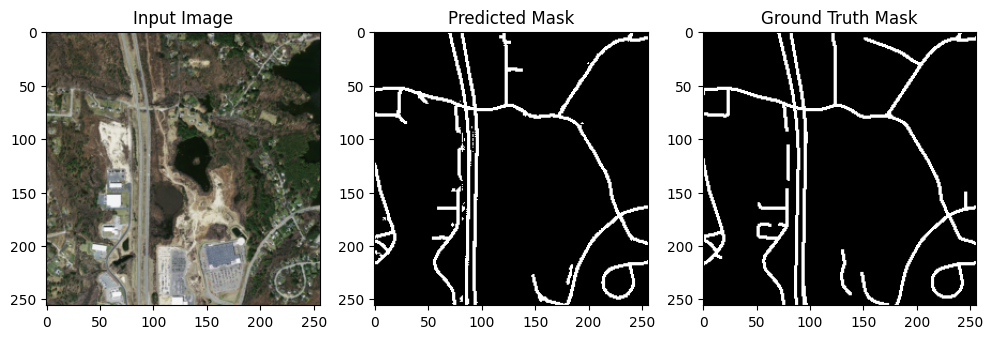

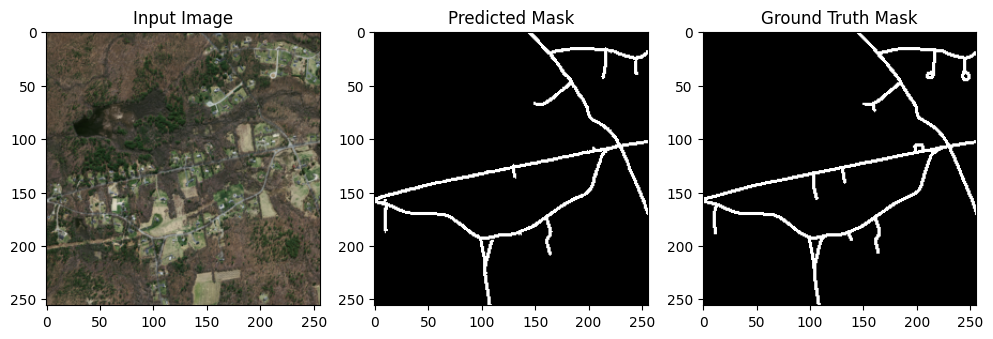

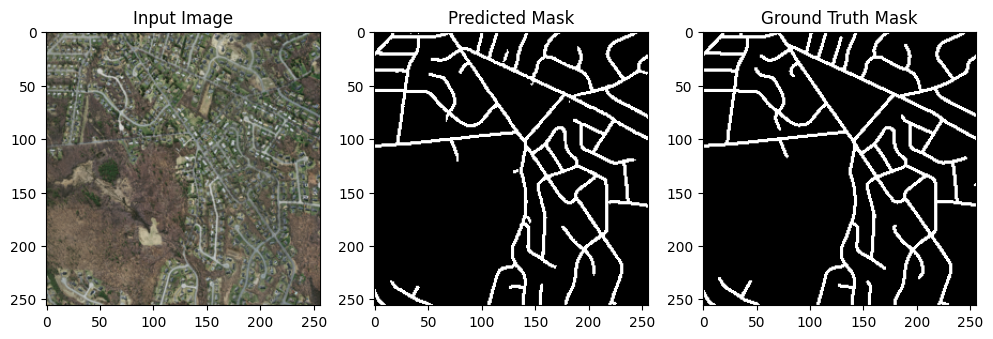

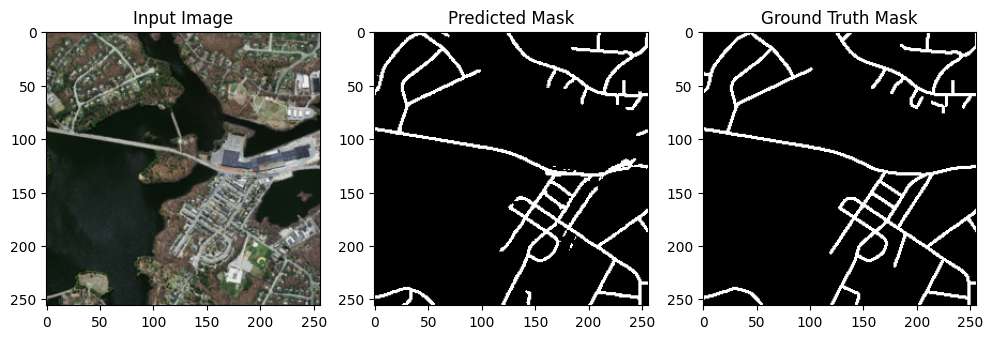

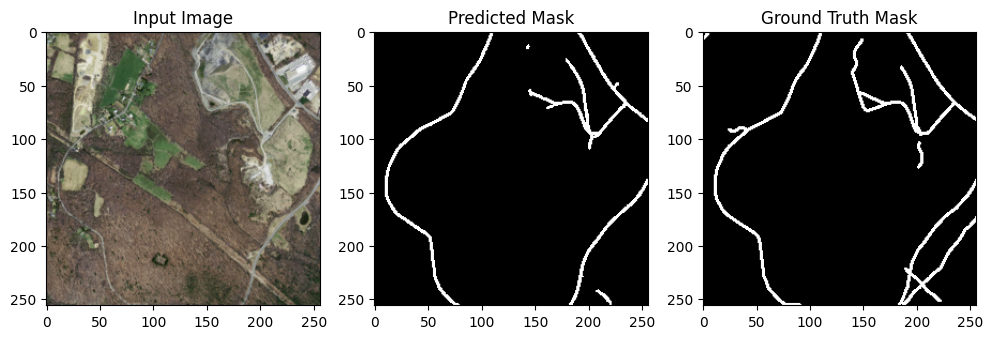

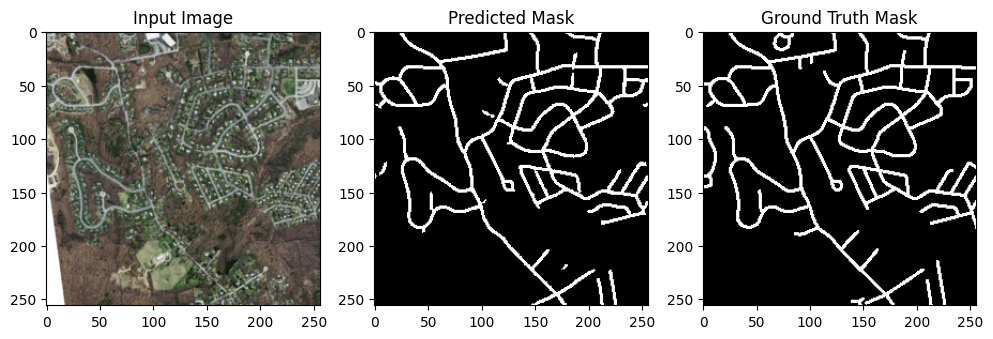

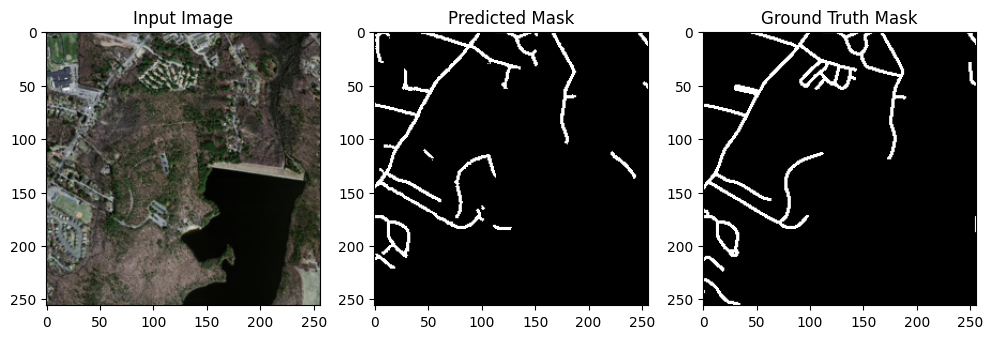

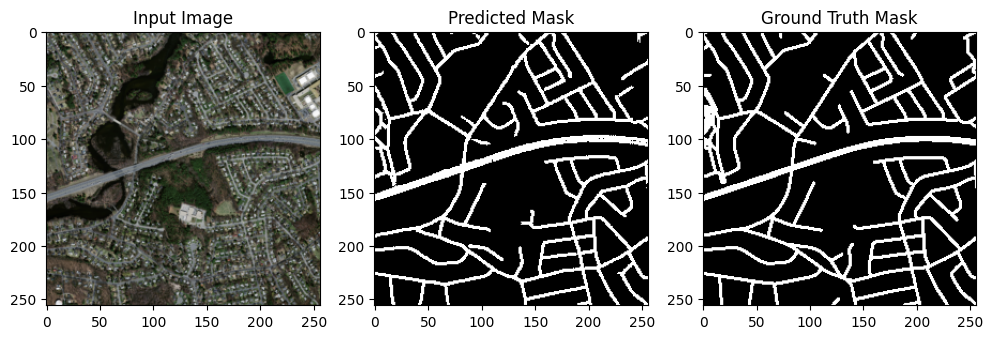

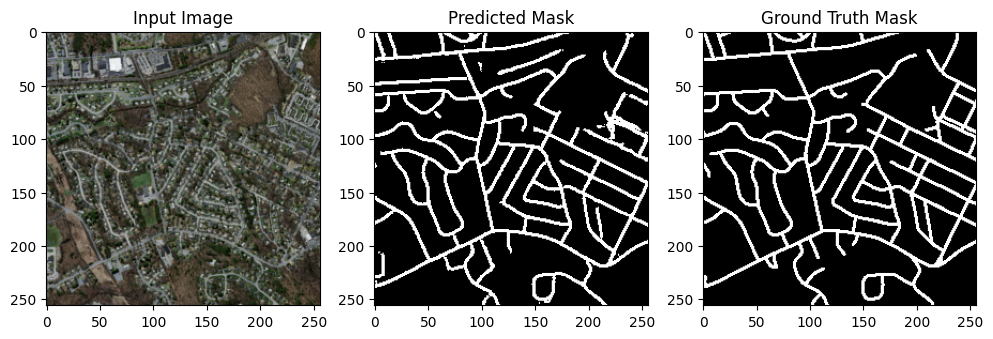

In [ ]:
import matplotlib.pyplot as plt

for i in range(13,22):  # show 3 samples
    img, mask = test_dataset[i]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = generator(img_tensor)[0][0].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0).cpu() * 0.5 + 0.5)
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(mask[0].cpu(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.show()
